# A late night ensemble of the best public kernels
* You can also see a sample meter below, using the [clean weather data](https://www.kaggle.com/hmendonca/clean-weather-data-eda)

Kernels:
* https://www.kaggle.com/rohanrao/ashrae-half-and-half
* https://www.kaggle.com/kimtaegwan/what-s-your-cv-method
* https://www.kaggle.com/nz0722/aligned-timestamp-lgbm-by-meter-type
* https://www.kaggle.com/isaienkov/keras-nn-with-embeddings-for-cat-features-1-15

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

sub = None
for dirname, _, filenames in os.walk('/kaggle/input/subs20191106/'):
    for filename in filenames:
        filename = os.path.join(dirname, filename)
        print(filename)
        if sub is None:
            sub = pd.read_csv(filename)
        else:
            sub.meter_reading += pd.read_csv(filename, usecols=['meter_reading']).meter_reading
    sub.meter_reading = sub.meter_reading.clip(lower=0) / len(filenames)

sub.describe()

/kaggle/input/subs20191106/submission_3.csv
/kaggle/input/subs20191106/submission_1.csv
/kaggle/input/subs20191106/submission.csv
/kaggle/input/subs20191106/submission_2.csv


,row_id,meter_reading
count,4.169760e+07,4.169760e+07
mean,2.084880e+07,4.572915e+02
std,1.203706e+07,8.307676e+03
min,0.000000e+00,0.000000e+00
25%,1.042440e+07,2.259057e+01
50%,2.084880e+07,7.674915e+01
75%,3.127320e+07,2.287860e+02
max,4.169760e+07,1.181271e+07


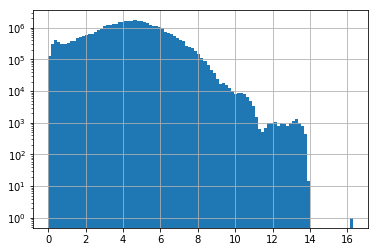

In [2]:
# prediction's log-log histogram:
ax = np.log1p(sub.meter_reading).hist(bins=100)
ax.set_yscale('log')

In [3]:
path = '../input/clean-weather-data-eda'
building = pd.read_csv(f'{path}/building_metadata.csv.gz', dtype={'building_id':np.uint16, 'site_id':np.uint8})

In [4]:
train = pd.read_csv(f'{path}/train.csv.gz', dtype={'building_id':np.uint16, 'meter':np.uint8}, parse_dates=['timestamp'])
train = train.merge(building, on='building_id', how='left')
train.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count
0,46,0,2016-01-01,53.2397,0,11,9045,2016.000000,3.740845
1,74,0,2016-01-01,43.0013,0,8,387638,1997.000000,3.740845
2,93,0,2016-01-01,52.4206,0,6,33370,1982.000000,3.740845
3,105,0,2016-01-01,23.3036,1,0,50623,1967.957037,5.000000
4,106,0,2016-01-01,0.3746,1,0,5374,1967.957037,4.000000


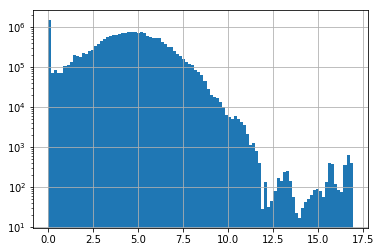

In [5]:
# target's log-log histogram:
ax = np.log1p(train.meter_reading).hist(bins=100)
ax.set_yscale('log')

In [6]:
test = pd.read_csv(f'{path}/test.csv.gz', dtype={'building_id':np.uint16, 'meter':np.uint8}, parse_dates=['timestamp'])
test['meter_reading'] = sub.meter_reading
test = test.merge(building, on='building_id', how='left')
test.head()

,row_id,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count
0,0,0,0,2017-01-01,135.220691,0,0,7432,2008.0,3.740845
1,1,1,0,2017-01-01,66.338751,0,0,2720,2004.0,3.740845
2,2,2,0,2017-01-01,8.213323,0,0,5376,1991.0,3.740845
3,3,3,0,2017-01-01,214.994307,0,0,23685,2002.0,3.740845
4,4,4,0,2017-01-01,908.794069,0,0,116607,1975.0,3.740845


In [7]:
weather_trn = pd.read_csv(f'{path}/weather_train.csv.gz', parse_dates=['timestamp'],
                                                       dtype={'site_id':np.uint8, 'air_temperature':np.float16},
                                                       usecols=['site_id', 'timestamp', 'air_temperature'])
weather_tst = pd.read_csv(f'{path}/weather_test.csv.gz', parse_dates=['timestamp'],
                                                       dtype={'site_id':np.uint8, 'air_temperature':np.float16},
                                                       usecols=['site_id', 'timestamp', 'air_temperature'])
train = train.merge(weather_trn, on=['site_id', 'timestamp'], how='left')
test = test.merge(weather_tst, on=['site_id', 'timestamp'], how='left')

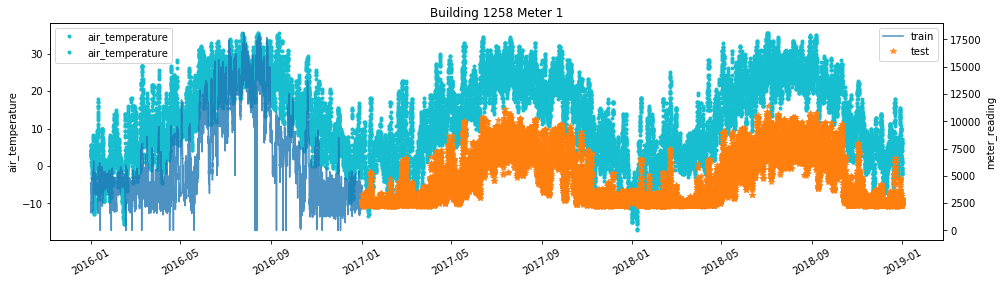

In [8]:
building_id = 1258
meter = 1 # pick a meter

train_sample = train[(train['building_id'] == building_id) & (train['meter'] == meter)]  # same train sample as above
test_sample = test[(test['building_id'] == building_id) & (test['meter'] == meter)]  # and the same meter in the test set

fig, ax = plt.subplots(figsize=(16,4))
plt.title(f'Building {building_id} Meter {meter}')
ax.xaxis.set_tick_params(rotation=30, labelsize=10)
ax2 = ax.twinx()

# plot training sample
dates = matplotlib.dates.date2num(train_sample['timestamp'])
ax2.plot_date(dates, train_sample['meter_reading'], '-', label='train', alpha=0.8)
ax.plot_date(dates, train_sample['air_temperature'], '.', color='tab:cyan', label='air_temperature')

# plot test sample
dates = matplotlib.dates.date2num(test_sample['timestamp'])
ax2.plot_date(dates, test_sample['meter_reading'], '*', label='test', alpha=0.8)
ax.plot_date(dates, test_sample['air_temperature'], '.', color='tab:cyan', label='air_temperature')

ax.set_ylabel('air_temperature'); ax2.set_ylabel('meter_reading')
ax.legend(loc='upper left'); ax2.legend(loc='upper right')

In [9]:
sub.to_csv(f'submission.csv', index=False, float_format='%g')

### Conclusions?
It looks like the models fail to predict the extremes, as both very low and very high values don't appear in the histograms